# Application of ARIMA, LSTM and PROPHET for Future Sales Prediction

This Jupyter notebook is based on the following Medium article: https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b

The algorithms ARIMA, LSTM and Facebook PROPHET are applied to the Kaggle dataset "Predict Future Sales" and compared. 

## Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pmdarima
import statsmodels.tsa.api as smt

from tensorflow.keras import models, layers, preprocessing as kprocessing

from fbprophet import Prophet

## Explorative Data Analysis

### Parsing

In [4]:
# Read in CSV from disk
df = pd.read_csv('data/sales_data.csv')

In [5]:
# Verfy shape of the dataframe
df.shape

(2935849, 6)

In [6]:
df.head(n=5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
df.tail(n=5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


### Reshaping

In [8]:
# We only want to use the data and the number of products sold --> delete the other features
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [9]:
df = df.groupby('date')['item_cnt_day'].sum().rename('sales')

In [10]:
df.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

### Verification of data types

In [11]:
df.dtypes

dtype('float64')

### Duplicates

In [12]:
df.duplicated().any()

True

In [15]:
df[df.duplicated(keep=False)].head(n=50)

date
2013-01-04    6617.0
2013-01-14    2595.0
2013-01-21    2636.0
2013-01-22    2775.0
2013-01-24    3016.0
2013-01-29    2764.0
2013-02-01    3817.0
2013-02-03    5068.0
2013-02-04    2330.0
2013-02-05    3302.0
2013-02-27    3014.0
2013-03-18    3113.0
2013-03-26    3914.0
2013-03-27    3673.0
2013-03-30    6617.0
2013-04-03    2579.0
2013-04-08    2506.0
2013-04-11    3315.0
2013-04-15    2508.0
2013-04-18    2728.0
2013-04-30    3914.0
2013-05-03    3914.0
2013-05-10    3435.0
2013-05-14    1964.0
2013-05-15    2506.0
2013-05-20    2712.0
2013-05-23    3054.0
2013-05-24    4068.0
2013-06-03    3239.0
2013-06-05    3418.0
2013-06-17    3421.0
2013-06-19    3315.0
2013-06-28    3994.0
2013-07-01    3391.0
2013-07-04    3630.0
2013-07-07    4666.0
2013-07-09    3237.0
2013-07-15    3145.0
2013-07-23    3448.0
2013-07-25    3436.0
2013-07-27    5227.0
2013-07-30    3501.0
2013-08-01    3218.0
2013-08-04    4297.0
2013-08-05    3435.0
2013-08-06    3237.0
2013-08-07    3673.0
2013-08-

### Missing Values

In [16]:
df.isna().any()

False

### Data Ranges

In [17]:
df.describe()

count     1034.000000
mean      3528.245648
std       1584.687467
min       1274.000000
25%       2472.250000
50%       3145.000000
75%       4257.000000
max      13343.000000
Name: sales, dtype: float64

### Visualization

<AxesSubplot:title={'center':'Number of sold products per day'}, xlabel='date'>

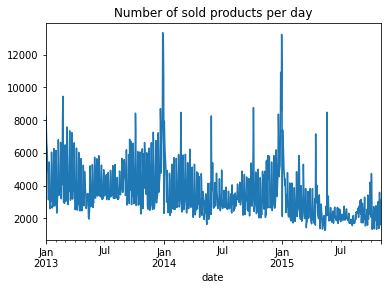

In [20]:
df.plot(title="Number of sold products per day")

### Outliers

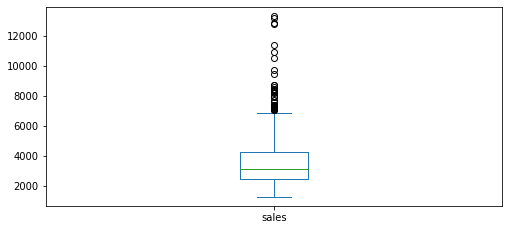

In [26]:
_ = df.plot(kind='box', subplots=True, layout=(7, 2), figsize=(18, 30), sharex=False)

In [27]:
# Find top 5 values --> they are all at the end of a year (companies buy the software for the next year)
df.nlargest(n=5)

date
2013-12-28    13343.0
2014-12-30    13236.0
2013-12-29    12863.0
2013-12-30    12823.0
2014-12-31    11394.0
Name: sales, dtype: float64

## Data Preprocessing